In [16]:
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch

In [17]:
mooring_shelfExtended_kogur = xr.open_dataset(r'D:\MScData\mooring_shelfExtended_kogur.nc')
mooring_shelfExtended = xr.open_dataset(r'D:\MScData\mooring_shelfExtended.nc')
mooring_kogur = xr.open_dataset(r'D:\MScData\mooring_kogur.nc')
mooring_north = xr.open_dataset(r'D:\MScData\mooring_north.nc')
depth = xr.open_dataset(r'D:\MScData\Depth_res.nc')['Depth'].sel(Y=slice(65,79)).sel(X=slice(-30,12))
depth_no_nan = depth

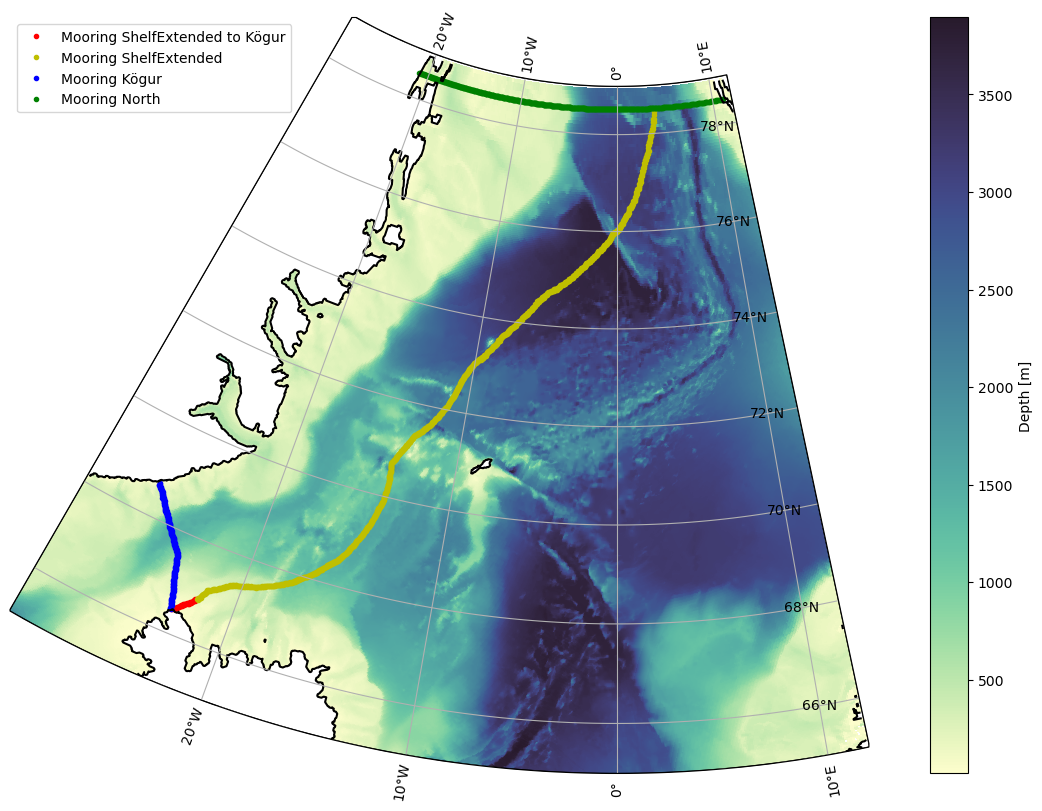

In [18]:
depth = depth.where(depth > 0, np.nan)

# Plot map and mooring locations
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.NorthPolarStereo()}, layout='constrained') # central_longitude=-10

extent = [-30,12,65,79]

mesh = ax.pcolormesh(depth.X, depth.Y, depth, cmap=cmo.deep, transform=ccrs.PlateCarree())
cbar = fig.colorbar(mesh)
cbar.set_label('Depth [m]')

XC = [mooring_shelfExtended_kogur["XC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]
YC = [mooring_shelfExtended_kogur["YC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]
ax.plot(XC, YC, "r.", transform=ccrs.PlateCarree(), label='Mooring ShelfExtended to Kögur')

XC = [mooring_shelfExtended["XC"][x].values[0][0] for x in mooring_shelfExtended['mooring']]
YC = [mooring_shelfExtended["YC"][x].values[0][0] for x in mooring_shelfExtended['mooring']]
ax.plot(XC, YC, "y.", transform=ccrs.PlateCarree(), label='Mooring ShelfExtended')

XC = [mooring_kogur["XC"][x].values[0][0] for x in mooring_kogur['mooring']]
YC = [mooring_kogur["YC"][x].values[0][0] for x in mooring_kogur['mooring']]
ax.plot(XC, YC, "b.", transform=ccrs.PlateCarree(), label='Mooring Kögur')

XC = [mooring_north["XC"][x].values[0][0] for x in mooring_north['mooring']]
YC = [mooring_north["YC"][x].values[0][0] for x in mooring_north['mooring']]
ax.plot(XC, YC, "g.", transform=ccrs.PlateCarree(), label='Mooring North')

ax.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

# Add gridlines and format them
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.legend(loc='upper left')

In [19]:
from FW import FWT
ref_salinity = 34.9

In [20]:
kogur = FWT(mooringDataset=mooring_kogur,ref_salinity=ref_salinity)

Cutting out the oceandataset.


c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\oceanspy\subsample.py:1561: UserWarning: 
Time resampling drops variables on `time_midp` dimension.
Dropped variables: ['time_midp'].
  return cutout(self._od, **kwargs)


Computing horizontal volume transport.


In [21]:
shelfExtended = FWT(mooringDataset=mooring_shelfExtended,ref_salinity=ref_salinity)

Cutting out the oceandataset.


c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\oceanspy\subsample.py:1561: UserWarning: 
Time resampling drops variables on `time_midp` dimension.
Dropped variables: ['time_midp'].
  return cutout(self._od, **kwargs)


Computing horizontal volume transport.


In [22]:
shelfExtendedKogur = FWT(mooringDataset=mooring_shelfExtended_kogur,ref_salinity=ref_salinity)

Cutting out the oceandataset.


c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\oceanspy\subsample.py:1561: UserWarning: 
Time resampling drops variables on `time_midp` dimension.
Dropped variables: ['time_midp'].
  return cutout(self._od, **kwargs)


Computing horizontal volume transport.


In [23]:
north = FWT(mooringDataset=mooring_north,ref_salinity=ref_salinity)

Cutting out the oceandataset.


c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\oceanspy\subsample.py:1561: UserWarning: 
Time resampling drops variables on `time_midp` dimension.
Dropped variables: ['time_midp'].
  return cutout(self._od, **kwargs)


Computing horizontal volume transport.


In [24]:
kogur = kogur.mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0)
north = north.mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0)
shelfExtended = shelfExtended.mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0)
shelfExtendedKogur = shelfExtendedKogur.mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0)

In [25]:
display(kogur)

<xarray.DataArray (Z: 216, mooring: 199)>
array([[            nan, -2.54703283e-05, -2.72570931e-05, ...,
        -3.79458774e-07, -4.07743156e-08,             nan],
       [            nan, -3.58691307e-05, -3.80409077e-05, ...,
        -2.75871125e-07,  9.66982741e-08,             nan],
       [            nan, -4.46133070e-05, -4.69987498e-05, ...,
         7.83303881e-08,  2.55228121e-07,             nan],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])
Coordinates:
  * Z             (Z) float64 -1.0 -3.5 -7.0 ... -3.922e+03 -3.942e+03
  * mooring       (mooring) int64 0 1 2 3 4 5 6 ... 192 193 194 195 196 197 198
    drF           (Z) float64 2.0 3.0 4.0 5.0 6.0 ... 19.0 19.0 19.0 19.0 19.0
    mooring_dist  (mooring) float64 0.0 1.686 3.371 5.055 ... 378.5 380.2 382.8
    Y             int64 0
    X             int64 0
    XC            (mooring) float64 -26.28 -26.28 -26.28 ... -23.05 -22.99
    YC            (mooring) float64 68.69 68.67 68.66 68.64 ... 66.5 66.48 66.48
    Xind          (mooring) float64 -26.28 -26.28 -26.28 ... -23.05 -22.99
    Yind          (mooring) float64 68.69 68.67 68.66 68.64 ... 66.5 66.48 66.48

Text(0, 0.5, 'mSv')

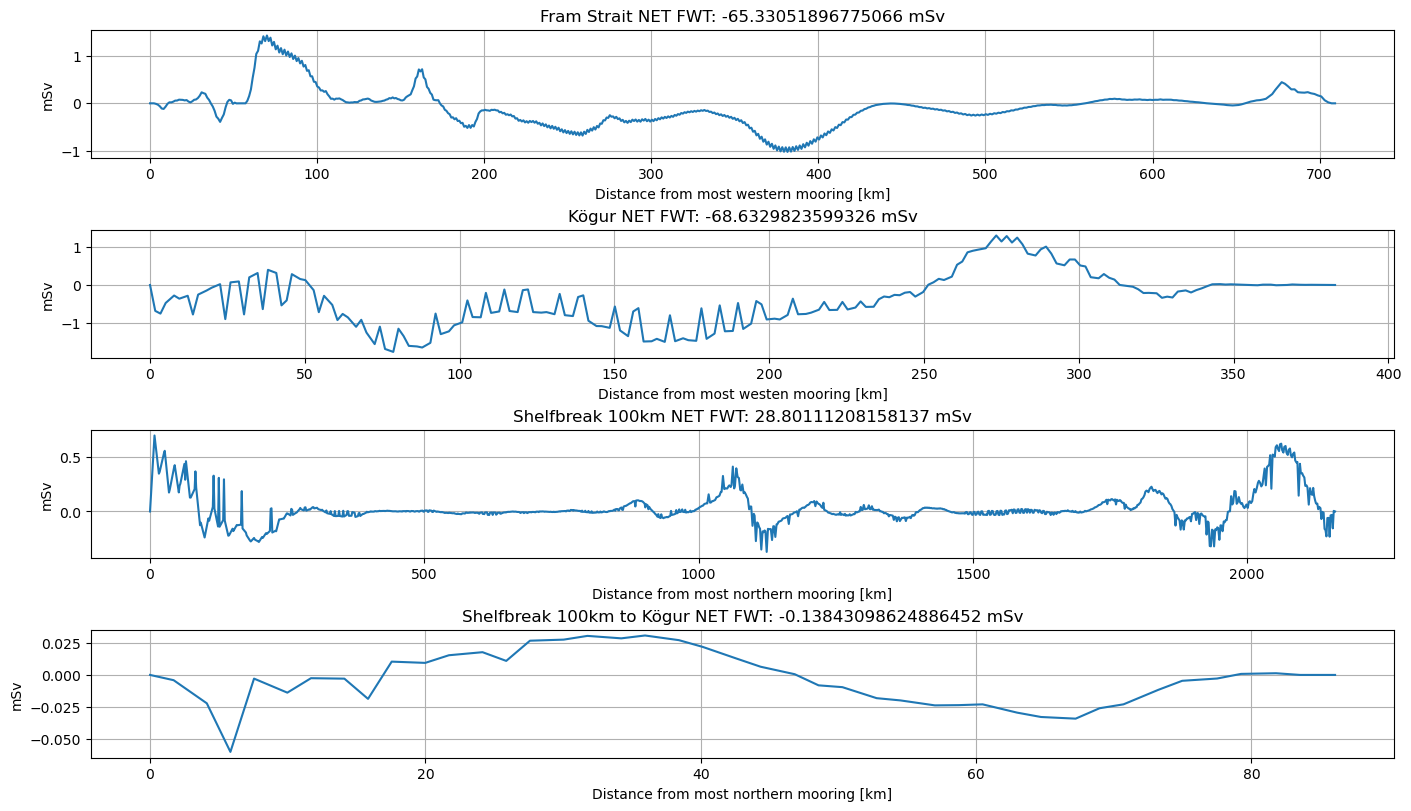

In [30]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(14,8),layout='constrained')
ax1.plot(north.mooring_dist,north.sum(dim='Z')*1000)
ax1.set_title(f'Fram Strait NET FWT: {north.sum(dim="Z").sum(dim="mooring").values*1000} mSv')
ax1.grid()
ax1.set_xlabel('Distance from most western mooring [km]')
ax1.set_ylabel('mSv')

ax2.plot(kogur.mooring_dist,kogur.sum(dim='Z')*1000)
ax2.set_title(f'Kögur NET FWT: {kogur.sum(dim="Z").sum(dim="mooring").values*1000} mSv')
ax2.grid()
ax2.set_xlabel('Distance from most westen mooring [km]')
ax2.set_ylabel('mSv')

ax3.plot(shelfExtended.mooring_dist,shelfExtended.sum(dim='Z')*1000)
ax3.set_title(f'Shelfbreak 100km NET FWT: {shelfExtended.sum(dim="Z").sum(dim="mooring").values*1000} mSv')
ax3.grid()
ax3.set_xlabel('Distance from most northern mooring [km]')
ax3.set_ylabel('mSv')

ax4.plot(shelfExtendedKogur.mooring_dist,shelfExtendedKogur.sum(dim='Z')*1000)
ax4.set_title(f'Shelfbreak 100km to Kögur NET FWT: {shelfExtendedKogur.sum(dim="Z").sum(dim="mooring").values*1000} mSv')
ax4.grid()
ax4.set_xlabel('Distance from most northern mooring [km]')
ax4.set_ylabel('mSv')

Text(0.5, 1.0, 'Kögur')

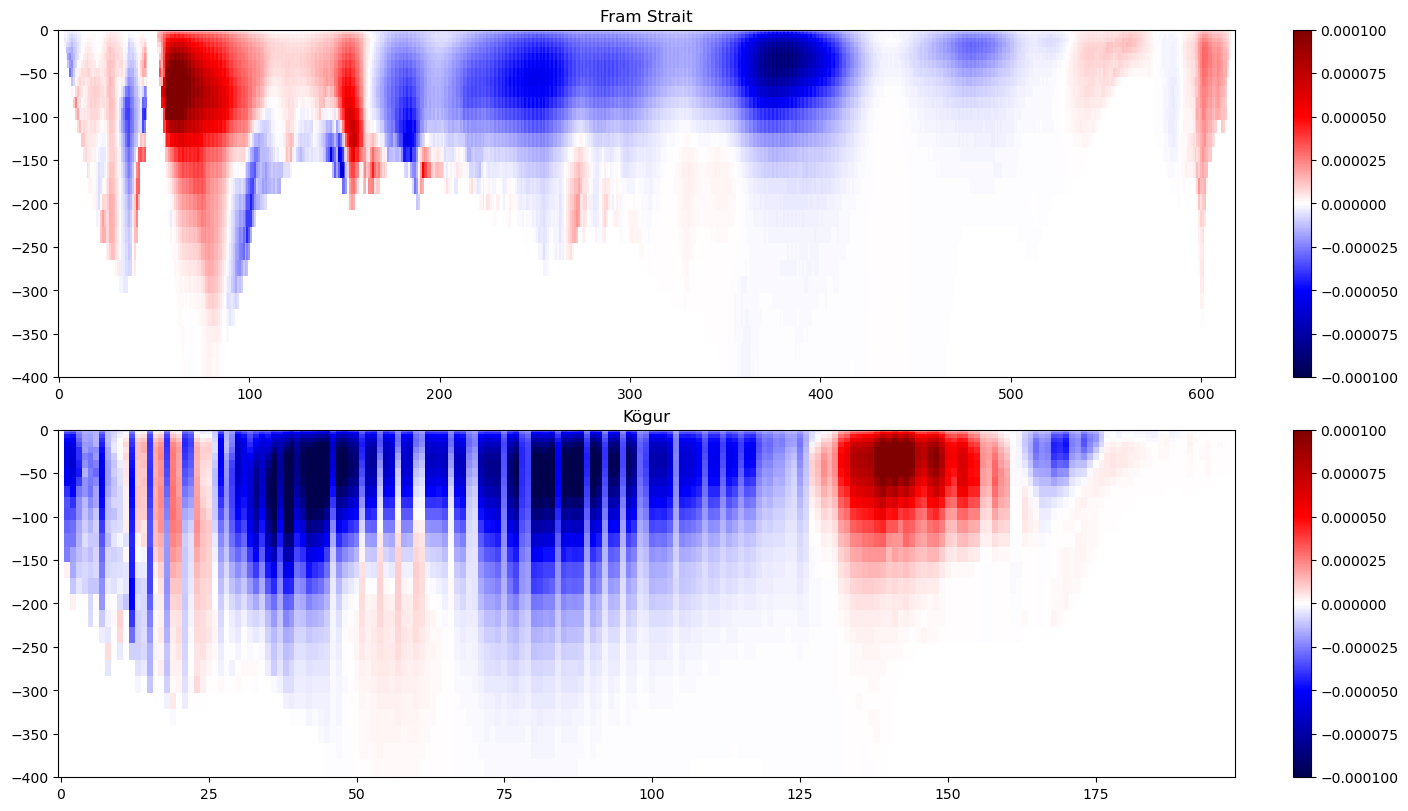

In [33]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,8),layout='constrained')
mesh = ax1.pcolormesh(north.mooring,north.Z,north,cmap='seismic',vmin=-0.0001,vmax=0.0001)
cbar = fig.colorbar(mesh)
ax1.set_ylim(-400,0)
ax1.set_title('Fram Strait')

mesh = ax2.pcolormesh(kogur.mooring,kogur.Z,kogur,cmap='seismic',vmin=-0.0001,vmax=0.0001)
cbar = fig.colorbar(mesh)
ax2.set_ylim(-400,0)
ax2.set_title('Kögur')

In [28]:
# print("### Reference salinity of 32.35 ###")
# print('Fram Strait: ',north.isel(mooring=-1).mean("path").values*1000," mSv")
# print('Shelfbreak100km: ',shelfExtended.isel(mooring=-1).mean("path").values*1000 + shelfExtendedKogur.isel(mooring=-1).mean("path").values*1000," mSv")
# print('Kögur: ',kogur.isel(mooring=-1).mean("path").values*1000," mSv")

# Shelfbreak 100km

ValueError: hue must be one of None, 'X', 'XC', 'Xind', 'Y', 'YC', 'Yind', 'Z', 'drF', 'mooring', 'mooring_dist'. Received 'path' instead.

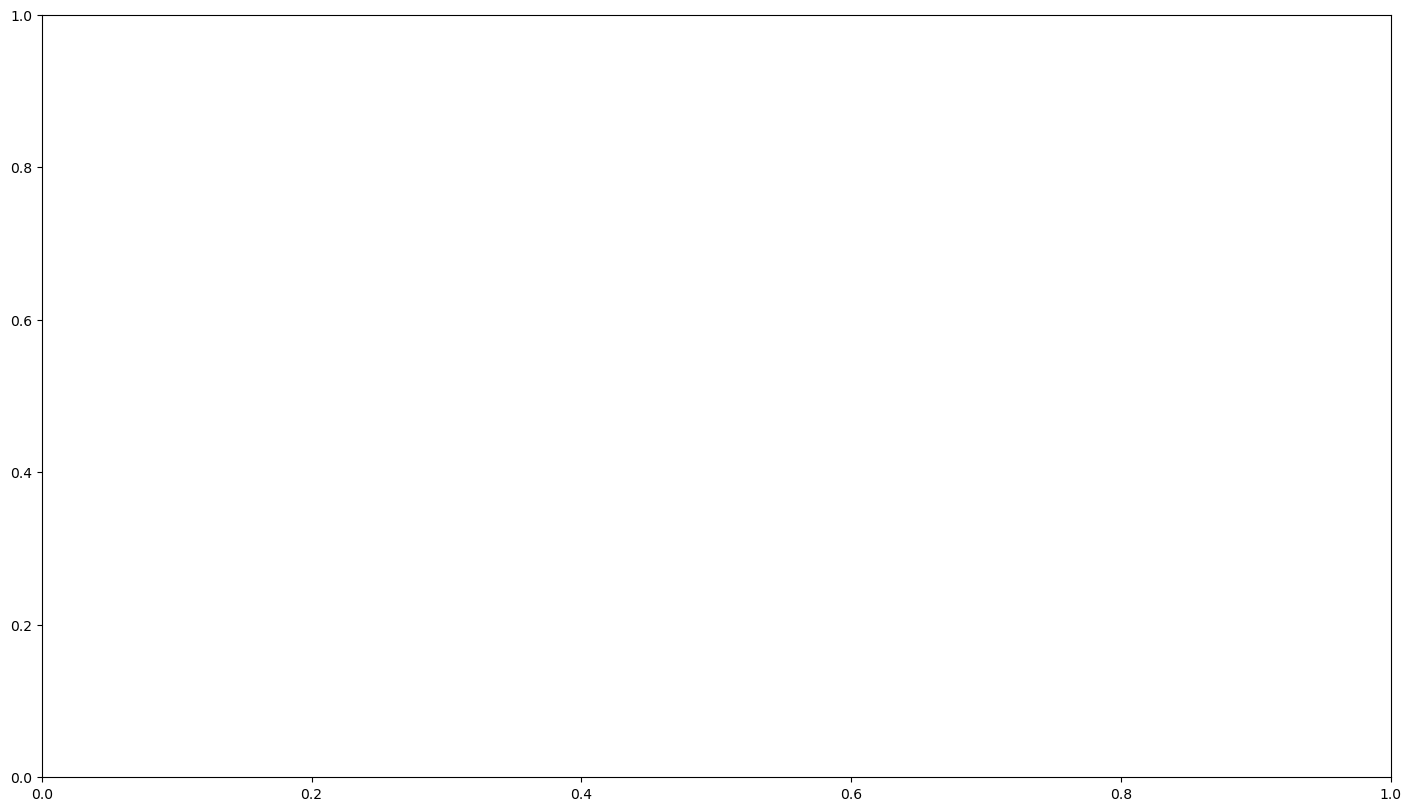

In [29]:
fig, ax = plt.subplots(figsize=(14,8),layout='constrained')
lines = shelfExtended.squeeze().plot.line(hue="path", linewidth=3)
tot_mean_FWT_moor = shelfExtended.isel(mooring=-1).mean('path')
title = ax.set_title(
    "TOTAL MEAN FRESH WATER TRANSPORT Shelfbreak100km: {0:.5f} mSv" "".format(tot_mean_FWT_moor.values*10**3)
)

# Could do
- Shifted correlation of time series of FWT of each transect
- Mask pos/neg numb
- Usikkerhet i referanse salinitet

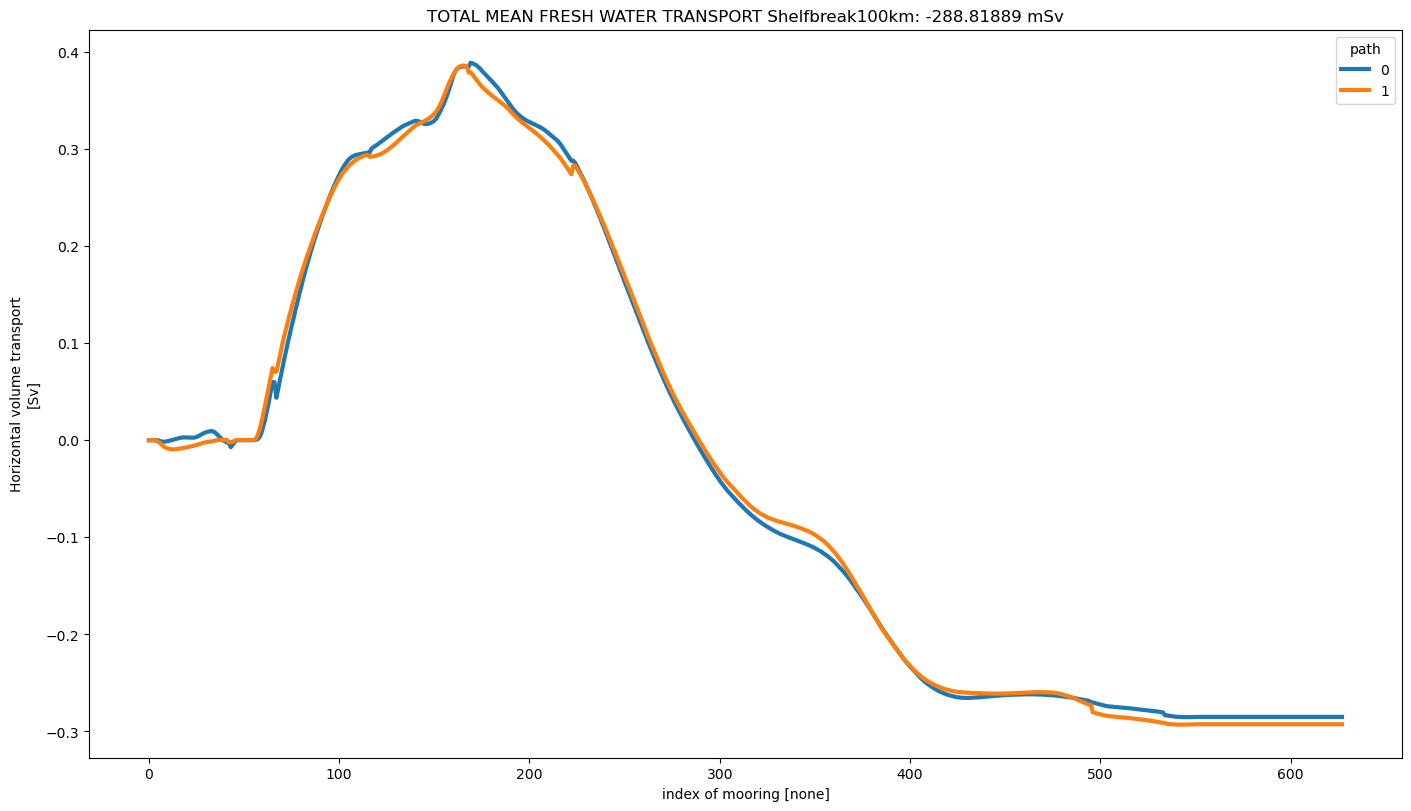

In [ ]:
fig, ax = plt.subplots(figsize=(14,8),layout='constrained')
lines = north.squeeze().plot.line(hue="path", linewidth=3)
tot_mean_FWT_moor = north.isel(mooring=-1).mean('path')
title = ax.set_title(
    "TOTAL MEAN FRESH WATER TRANSPORT Shelfbreak100km: {0:.5f} mSv" "".format(tot_mean_FWT_moor.values*10**3)
)